# Assessmet of key metrics in 1/20th degree MOM6 experiment: Overturning

In [1]:
%matplotlib inline
import xarray as xr
import numpy as np
import cosima_cookbook as cc
from collections import OrderedDict
from dask.distributed import Client
import cftime
from datetime import timedelta
from gsw import alpha, SA_from_SP, p_from_z, CT_from_pt, beta, sigma1
import matplotlib.path as mpath

import matplotlib.pyplot as plt
import cmocean.cm as cmo
import matplotlib.colors as col
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter
import matplotlib.ticker as mticker

In [2]:
plt.rcParams['figure.dpi'] = 96
plt.rcParams["font.size"] = 12
plt.rcParams["axes.titlesize"] = 12
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["legend.fontsize"] = 12
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["lines.linewidth"] = 1.5
plt.rcParams["lines.markersize"] = 3
plt.rcParams['hatch.color'] = 'k'
plt.rcParams["savefig.facecolor"] = 'white'

In [3]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 8
Total threads: 48,Total memory: 180.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43617,Workers: 8
Dashboard: /proxy/8787/status,Total threads: 48
Started: Just now,Total memory: 180.00 GiB
Comm: tcp://127.0.0.1:43569,Total threads: 6
Dashboard: /proxy/42021/status,Memory: 22.50 GiB
Nanny: tcp://127.0.0.1:42437,


## Load data

In [4]:
session = cc.database.create_session()
session_005 = cc.database.create_session(
    'panan_005deg_jra55_ryf.db')
path_output_SWMT = '/g/data/e14/cs6673/mom6_comparison/data_DSW/'
# start_time = '1991-01-01'
# end_time = '1995-12-31'

In [5]:
exptdict = OrderedDict([
    ('pa_z_v13', # 1/10th panantarctic zstar run with ACCESS-OM2-01 year 200 IC + BF
     {'expt': 'panant-01-zstar-v13'}),
    ('pa_z_yr2', # 1/10th panantarctic zstar run with ACCESS-OM2-01 year 2 IC + BF
     {'expt': 'panant-01-zstar-ACCESSyr2'}),
    ('pa_z_005', # 1/20th panantarctic zstar run with ACCESS-OM2-01 year 2 IC + BF
     {'expt': 'panan_005deg_jra55_ryf'})
])

In [6]:
DSW_region = {
'name': ['Weddell', 'Prydz', 'Adelie', 'Ross'],
'name_long': ['Weddell Sea', 'Prydz Bay', 'Adélie Coast', 'Ross Sea'],
'lon': [[-60, -35, -48, -62, -60],
        [48, 73, 74, 48, 48],
        [128-360, 152-360, 152-360, 128-360, 128-360],
        [185-360, 160-360, 164-360, 172-360, 185-360]],
'lat': [[-71, -75, -78, -75, -71],
        [-65, -66.5, -69, -68, -65],
        [-64.5, -66, -69, -67.5, -64.5],
        [-78, -78, -73, -71.5, -78]]}

## Load data

In [7]:
%%time
ekeys = ['pa_z_v13', 'pa_z_yr2', 'pa_z_005']
for ekey in ekeys:
    e = exptdict[ekey]
    if ekey == 'pa_z_005':
        session = session_005
    
    # Transport stream function
    psi = cc.querying.getvar(
        e['expt'], 'vmo', session, frequency='1 monthly',
        # start_time=start_time, end_time=end_time,
        chunks={'xh': '200MB', 'yq': '200MB'}).sum('xh')
    e['psi'] = psi/1e9

Exception during reset or similar
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/sqlalchemy/pool/base.py", line 763, in _finalize_fairy
    fairy._reset(pool, transaction_was_reset)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/sqlalchemy/pool/base.py", line 1038, in _reset
    pool._dialect.do_rollback(self)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/sqlalchemy/engine/default.py", line 683, in do_rollback
    dbapi_connection.rollback()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 22673524270912 and this is thread id 22672206599936.
Exception closing connection <sqlite3.Connection object at 0x149f072b2c60>
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-pa

CPU times: user 4.92 s, sys: 793 ms, total: 5.71 s
Wall time: 15.6 s


## Plots

In [8]:
def plot_overturning_at_different_latitudes_each_layer(expt, time_slice):

    e = exptdict[expt]
    if time_slice is None:
        psi = e['psi']
    else:
        psi = e['psi'].sel(time=time_slice)

    plt.subplot(1, 2, 1)
    for lat in range(-70, -30, 10):
        psi[:, 1:, :].sel(yq=lat, method='nearest').mean('time').plot(
            y='rho2_l', label=str(np.abs(lat)) + '°S')
    plt.gca().invert_yaxis()
    plt.legend()
    plt.axvline(0, color='k', linestyle='--')
    for r in psi.rho2_l[1:]:
        plt.axhline(r, xmin=.9, xmax=1, color='grey', lw=.5)

    plt.xlabel('Zonally integrated transport in layer (Sv)')
    plt.title(e['expt'] + ' (mean ' + time_slice.start + '-' +
              time_slice.stop + ')', fontweight='bold')

    plt.subplot(1, 2, 2)
    for lat in range(-70, -30, 10):
        psi[:, 1:, :].sel(yq=lat, method='nearest').mean('time').plot(
            y='rho2_l', label=str(np.abs(lat)) + '°S')
    plt.ylim(1037.3,1036.7)
    plt.legend()
    plt.axvline(0, color='k', linestyle='--')
    for r in psi.rho2_l[1:]:
        plt.axhline(r, xmin=.9, xmax=1, color='grey', lw=.5)

    plt.xlabel('Zonally integrated transport in layer (Sv)')
    plt.ylabel('')
    plt.title(e['expt'] + ' (mean ' + time_slice.start + '-' +
              time_slice.stop + ')', fontweight='bold')

    plt.show()

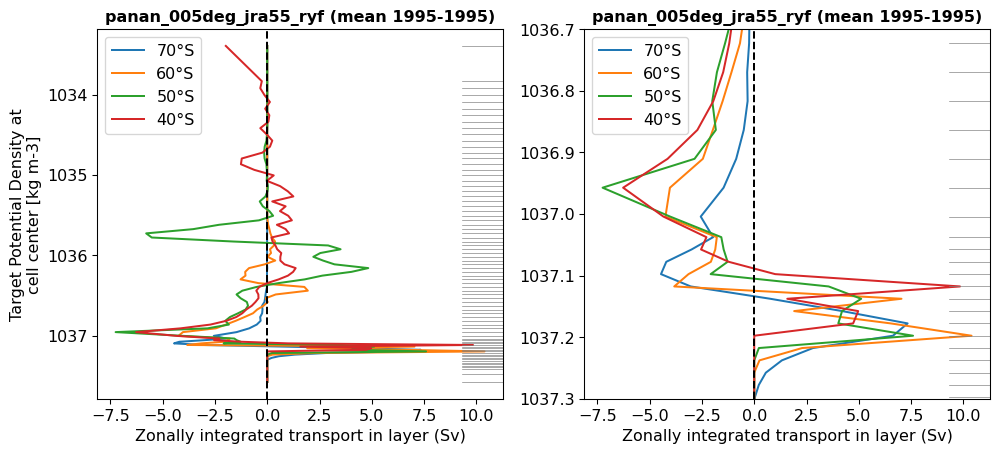

In [9]:
plt.figure(figsize=(12, 5))
expt = 'pa_z_005'
time_slice = slice('1995', '1995')
plot_overturning_at_different_latitudes_each_layer(expt, time_slice)

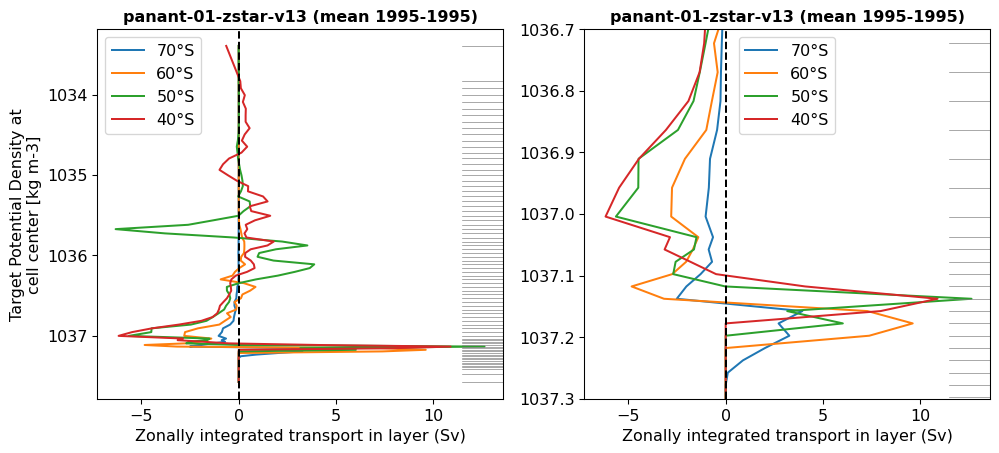

CPU times: user 9.99 s, sys: 973 ms, total: 11 s
Wall time: 46.7 s


In [10]:
plt.figure(figsize=(12, 5))
expt = 'pa_z_v13'
time_slice = slice('1995', '1995')
plot_overturning_at_different_latitudes_each_layer(expt, time_slice)

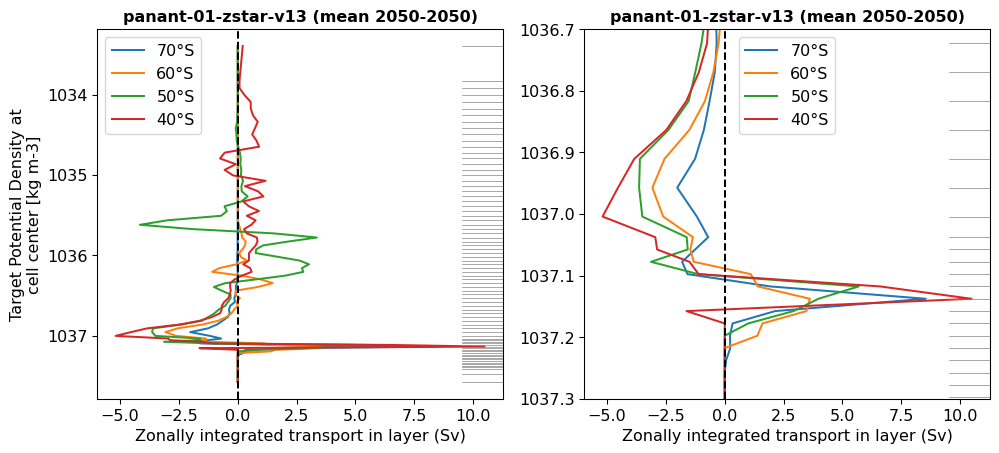

In [11]:
plt.figure(figsize=(12, 5))
expt = 'pa_z_v13'
time_slice = slice('2050', '2050')
plot_overturning_at_different_latitudes_each_layer(expt, time_slice)